## ДЗ 2.

Вам нужно будет загрузить и оформить датасет котиков, собак https://www.kaggle.com/andrewmvd/dog-and-cat-detection 
Нужно будет произвести также аугментацию данных
Затем обучить нейронную сеть на получившемся датасете используя модель с урока

In [2]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from google.colab import drive

In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
images_path = Path('/content/drive/MyDrive/Colab Notebooks/data/catdogs/images')
anno_path = Path('/content/drive/MyDrive/Colab Notebooks/data/catdogs/annotations')

In [5]:
def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [6]:
df_train = generate_train_df(anno_path)

In [7]:
print(df_train.shape)
df_train.head()

(3686, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/Colab Notebooks/data/ca...,133,200,dog,33,32,104,102
1,/content/drive/MyDrive/Colab Notebooks/data/ca...,333,500,dog,33,27,244,281
2,/content/drive/MyDrive/Colab Notebooks/data/ca...,500,333,dog,75,41,278,165
3,/content/drive/MyDrive/Colab Notebooks/data/ca...,300,225,cat,53,20,149,125
4,/content/drive/MyDrive/Colab Notebooks/data/ca...,500,333,dog,74,71,163,167


Преобразуем наши метки в классы:

In [8]:
class_dict = {'cat': 0, 'dog': 1}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

Преобразуем обрамляющий прямоугольник в изображение(маску) того же размера что и соотвествующее этому прямоугольнику изображение. Эта маска будет просто иметь 0 для заднего фона и 1 для области покрывающей обрамляющий прямоугольник.

In [9]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_mask(bb, x):
    """Создаем маску для обрамляющего прямоугольника такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Конвертируем маску Y в обрамляющий прямоугольник, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Генерируем массив обрамляющих прямоугольников из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])

def resize_image_bb(read_path,write_path,bb,sz):
    """Ресайзим изображение и его обрамляющий прямоугольник и записываем изображение в новый путь"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [10]:
new_paths = []
new_bbs = []
train_path_resized = Path('/content/drive/MyDrive/Colab Notebooks/data/catdogs/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

In [11]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,/content/drive/MyDrive/Colab Notebooks/data/ca...,133,200,1,33,32,104,102,/content/drive/MyDrive/Colab Notebooks/data/ca...,"[47.0, 109.0, 153.0, 350.0]"
1,/content/drive/MyDrive/Colab Notebooks/data/ca...,333,500,1,33,27,244,281,/content/drive/MyDrive/Colab Notebooks/data/ca...,"[16.0, 44.0, 168.0, 327.0]"
2,/content/drive/MyDrive/Colab Notebooks/data/ca...,500,333,1,75,41,278,165,/content/drive/MyDrive/Colab Notebooks/data/ca...,"[36.0, 67.0, 148.0, 248.0]"
3,/content/drive/MyDrive/Colab Notebooks/data/ca...,300,225,0,53,20,149,125,/content/drive/MyDrive/Colab Notebooks/data/ca...,"[26.0, 78.0, 166.0, 222.0]"
4,/content/drive/MyDrive/Colab Notebooks/data/ca...,500,333,1,74,71,163,167,/content/drive/MyDrive/Colab Notebooks/data/ca...,"[64.0, 66.0, 150.0, 145.0]"


In [12]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

(500, 375, 3)


In [13]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([157., 162., 325., 261.], dtype=float32)

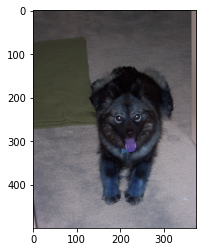

In [14]:
plt.imshow(im)

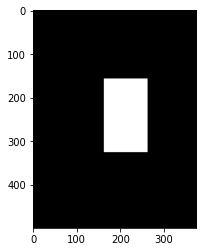

In [15]:
plt.imshow(Y, cmap='gray')

Аугментация данных. Будем использовать переворот, поворот, центральную обрезку и случайную обрезку.

In [16]:
# Вырезаем кусок с изображения
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Случайное вырезание части картинки
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

# Центральное вырезание 
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [17]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Поворачиваем наше изображение"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Возвращает случайное вырезание"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

# Трансформируем нашу картинку 
def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [18]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

/content/drive/MyDrive/Colab Notebooks/data/catdogs/images/Cats_Test698.png


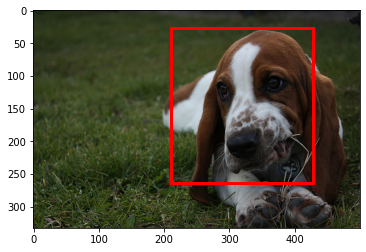

In [19]:
#Оригинал:
number = 51
im = cv2.imread(str(df_train.values[number][0]))
print(str(df_train.values[number][0]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[number][9])

In [21]:
df_train.values

array([[PosixPath('/content/drive/MyDrive/Colab Notebooks/data/catdogs/images/Cats_Test2873.png'),
        '133', '200', ..., 102,
        '/content/drive/MyDrive/Colab Notebooks/data/catdogs/images_resized/Cats_Test2873.png',
        array([ 47., 109., 153., 350.], dtype=float32)],
       [PosixPath('/content/drive/MyDrive/Colab Notebooks/data/catdogs/images/Cats_Test858.png'),
        '333', '500', ..., 281,
        '/content/drive/MyDrive/Colab Notebooks/data/catdogs/images_resized/Cats_Test858.png',
        array([ 16.,  44., 168., 327.], dtype=float32)],
       [PosixPath('/content/drive/MyDrive/Colab Notebooks/data/catdogs/images/Cats_Test580.png'),
        '500', '333', ..., 165,
        '/content/drive/MyDrive/Colab Notebooks/data/catdogs/images_resized/Cats_Test580.png',
        array([ 36.,  67., 148., 248.], dtype=float32)],
       ...,
       [PosixPath('/content/drive/MyDrive/Colab Notebooks/data/catdogs/images/Cats_Test1494.png'),
        '500', '313', ..., 275,
        '

In [22]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,/content/drive/MyDrive/Colab Notebooks/data/ca...,133,200,1,33,32,104,102,/content/drive/MyDrive/Colab Notebooks/data/ca...,"[47.0, 109.0, 153.0, 350.0]"
1,/content/drive/MyDrive/Colab Notebooks/data/ca...,333,500,1,33,27,244,281,/content/drive/MyDrive/Colab Notebooks/data/ca...,"[16.0, 44.0, 168.0, 327.0]"
2,/content/drive/MyDrive/Colab Notebooks/data/ca...,500,333,1,75,41,278,165,/content/drive/MyDrive/Colab Notebooks/data/ca...,"[36.0, 67.0, 148.0, 248.0]"
3,/content/drive/MyDrive/Colab Notebooks/data/ca...,300,225,0,53,20,149,125,/content/drive/MyDrive/Colab Notebooks/data/ca...,"[26.0, 78.0, 166.0, 222.0]"
4,/content/drive/MyDrive/Colab Notebooks/data/ca...,500,333,1,74,71,163,167,/content/drive/MyDrive/Colab Notebooks/data/ca...,"[64.0, 66.0, 150.0, 145.0]"


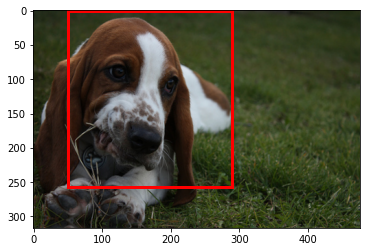

In [23]:
#После трансформации:
im, bb = transformsXY(str(df_train.values[number][0]),df_train.values[number][9],True )
show_corner_bb(im, bb)

### Датасет

Теперь, когда у нас есть дополнения к данным, мы можем создать набор данных PyTorch. Мы нормализуем изображения с помощью статистики ImageNet, потому что мы будем использовать предварительно обученную модель ResNet и применим аугментацию данных в нашем наборе данных во время обучения.

In [24]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [25]:
def normalize(im):
    """Нормализация данных с помощью статистики ImageNet"""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [26]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [27]:

train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [28]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

В качестве модели мы будем использовать очень простую предварительно обученную модель resNet-34. Поскольку здесь у нас есть две задачи, есть два последних слоя - регрессия ограничивающей рамки и классификатор изображений.

In [29]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

### Обучение

In [30]:
model = BB_model()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)
epochs = 4

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [31]:
for i in range(epochs):
    
    model.train()
    total = 0
    sum_loss = 0
    C=1000
    
    for x, y_class, y_bb in train_dl:
        batch = y_class.shape[0]
        x = x.float()
        #y_class = y_class.cuda()
        y_bb = y_bb.float()
#         print(y_bb.shape)
#         print(y_class.shape)
        out_class, out_bb = model(x)
#         print(out_bb.shape)
#         print(out_class.shape)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        loss = loss_class + loss_bb/C
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += batch
        sum_loss += loss.item()
    train_loss = sum_loss/total
    
    # Eval
    model.eval()
    val_total = 0
    val_sum_loss = 0
    correct = 0
    
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.float()
        #y_class = y_class.cuda()
        y_bb = y_bb.float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")

        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        val_sum_loss += loss.item()
        val_total += batch
    val_loss = val_sum_loss/val_total
    val_acc = correct/val_total
    
    print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))

train_loss 1.162 val_loss 0.916 val_acc 0.665
train_loss 0.916 val_loss 1.554 val_acc 0.587
train_loss 0.925 val_loss 1.437 val_acc 0.687
train_loss 0.869 val_loss 0.836 val_acc 0.687


### Тестирование

In [32]:
# resizing test image
im = read_image('/content/drive/MyDrive/Colab Notebooks/data/catdogs/images_resized/Cats_Test3683.png')
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/data/catdogs/images_resized/Cats_Test3683.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True